--**edits by [@Katharina Menz](https://www.kaggle.com/katharinamenz): This noteook was originally published by [@anasofiauzsoy](https://www.kaggle.com/anasofiauzsoy) under this [link](https://www.kaggle.com/anasofiauzsoy/tutorial-notebook) as a tutorial for the ["Contradictory, My Dear Watson" competition](https://www.kaggle.com/c/contradictory-my-dear-watson/overview). I didnt' change any of the content she wrote, but instead added explanations that helped me as a beginner to NLP better understand what she is doing. I spent many days and hours getting through this and hope that my added comments might help other beginners as well and save them some hours of googling :-) 
I will mark all my edits in the text with bold and with # KM: in the code.**--


Natural Language Inferencing (NLI) is a classic NLP (Natural Language Processing) problem that involves taking two sentences (the _premise_ and the _hypothesis_ ), and deciding how they are related- if the premise entails the hypothesis, contradicts it, or neither.

In this tutorial we'll look at the _Contradictory, My Dear Watson_ competition dataset, build a preliminary model using Tensorflow 2, Keras, and BERT, and prepare a submission file.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
#os.environ["WANDB_API_KEY"] = "0" ## to silence warning

In [3]:
from transformers import BertTokenizer, TFBertModel, TFAutoModel,AutoTokenizer
import matplotlib.pyplot as plt
import tensorflow as tf

## Downloading Data

The training set contains a premise, a hypothesis, a label (0 = entailment, 1 = neutral, 2 = contradiction), and the language of the text. For more information about what these mean and how the data is structured, check out the data page: https://www.kaggle.com/c/contradictory-my-dear-watson/data

In [4]:
!kaggle competitions download -c contradictory-my-dear-watson

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [5]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")

We can use the pandas head() function to take a quick look at the training set.

In [6]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


Let's look at one of the pairs of sentences.

In [7]:
train.premise.values[1]

'These are issues that we wrestle with in practice groups of law firms, she said. '

In [8]:
train.hypothesis.values[1]

'Practice groups are not permitted to work on these issues.'

In [9]:
train.label.values[1]

2

These statements are contradictory, and the label shows that.

Let's look at the distribution of languages in the training set.

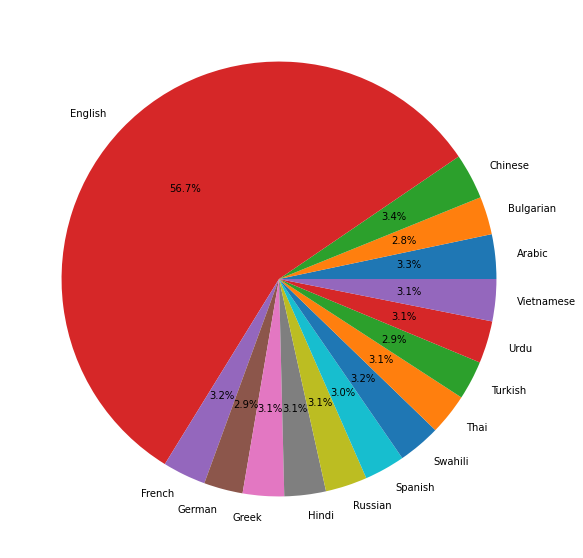

In [10]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

## Preparing Data for Input

--**edits by [@Katharina Menz](https://www.kaggle.com/katharinamenz): [@anasofiauzsoy](https://www.kaggle.com/anasofiauzsoy) will use a pre-trained BERT model combined with a classifier to make the predictions. First, the input text data will be fed into the BERT model (after they have been converted into tokens), which in turn outputs embbeddings of the words. The advantage to other types of embeddings is that the BERT embeddings are contextualized (the word "stick" in the sentence "Let's stick to the BERT model" would have a different numerical representation than the word "stick" in the sentence "Please don't throw that stick into the river" because the context in which the word appears is different in both sentences (I got the idea for this example from [here](http://jalammar.github.io/illustrated-bert/) which is a great explanation on how BERTs work and will definitely help to understand this tutorial better as well)). Predictions with contextualized embeddings are more accurate than with non-contextualized embeddings.**

**The fact that the embeddings are contextualized comes from the first (of two) parts of BERT'S training: Instead of parsing the text from left to right (or right to left), BERT takes the whole text in at once (that's why it's also called a bi-directional model, although no-directional would actually fit better) which helps it to put every word into a relation to the other words in the sentence.**

**After we receive the embeddings for the words in our text from BERT, we can input them into the classifier which will then in turn return the prediction labels 0,1, or 2.**--

To start out, we can use a pretrained model. Here, we'll use a multilingual BERT model from huggingface. For more information about BERT, see: https://github.com/google-research/bert/blob/master/multilingual.md

First, we download the tokenizer.

--**edits by [@Katharina Menz](https://www.kaggle.com/katharinamenz): We will first break down our text into tokens by using BERTS own tokenizer BertTokenizer. In order for the tokenizer to know how to tokenize, the BertTokenizer is given a language model 'bert-base-multilingual-cased' that [@anasofiauzsoy](https://www.kaggle.com/anasofiauzsoy) downloaded from the above mentioned link. This model includes more than 100 languages which is useful since our data also contains multiple languages.**--

In [11]:
#model_name = "bert-base-multilingual-cased"
#tokenizer = BertTokenizer.from_pretrained(model_name) # KM: this is the tokenizer we will use on our text data to tokenize it

model_name = "joeddav/xlm-roberta-large-xnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Tokenizers turn sequences of words into arrays of numbers. Let's look at an example:

In [12]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s)) # KM: split the sentence into tokens that are either words or sub-words
   tokens.append('[SEP]') # KM: a token called [SEP] (=separator) is added to mark end of each sentence
   return tokenizer.convert_tokens_to_ids(tokens) # KM: instead of returning the list of tokens, a list of each token ID is returned

--**edits by [@Katharina Menz](https://www.kaggle.com/katharinamenz): What happens in the 4 lines above is that the words are actually not only converted into tokens, but then those tokens are also turned into the IDs for each token**--

In [13]:
encode_sentence("I love machine learning") # KM: the output is a number for each word plus the ID for the [SEP] token

[87, 5161, 36279, 52080, 3]

BERT uses three kind of input data- input word IDs, input masks, and input type IDs.

These allow the model to know that the premise and hypothesis are distinct sentences, and also to ignore any padding from the tokenizer.

We add a [CLS] token to denote the beginning of the inputs, and a [SEP] token to denote the separation between the premise and the hypothesis. We also need to pad all of the inputs to be the same size. For more information about BERT inputs, see: https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel

--**edits by [@Katharina Menz](https://www.kaggle.com/katharinamenz): Let's break this down a little more:**

**To prepare our token IDs which we received through our function encode_sentence() to become input into BERT, we first concatenate the token ID list of each sentence in the hypothesis and premise column (remember that each sentence is already separated by the [SEP] token at the end which we added above) into one list and add another token ID at the very beginning (the ID for the token '[CLS]') which denotes the beginning. However, the output list of encode_sentence() will have a different length for each sentence from our data set which means we can't just construct a nice table out of all those concatenated lists to feed them to BERT. Instead, we will have to add zeros at the end of each ID list until it has the length of the longest list in the data set (corresponding to the longest hypothesis/premise pair). This process is called padding. This way, every ID list will have the same length and BERT will be able to accept them as input. This will be the variable "input word IDs" mentioned above and our first input variable for the BERT model.**

**However, we also need to tell BERT which of the IDs in the "input word IDs" actually belong to tokens that it should embed and which of them it should ignore because they are just padding. This is where input masks come into play: The input mask variable has the same size as the input word IDs variable but contains a 1 for each entry that is an actual token ID (which BERT should consider) and a 0 for eacht entry that is just padding and which BERT should ignore. This will be our second input argument "input masks" for the BERT model.**

**Lastly, BERT also needs to know which of the input word IDs belong to which sentence (i.e., hypthesis or premise). We can explain this to BERT by using the variable 'input type IDs' mentioned above. Again, this variable has the same size as as the input word IDs variable but this time it contains a 1 for each entry that belongs to sentence B (i.e., the premise) and a 0 for each entry that belongs to sentence A (i.e., the hypothesis), including our start token ID for '[CLS]'. "Input type IDs" will be our third and last input argument for BERT.**--

Now, we're going to encode all of our premise/hypothesis pairs for input into BERT.

In [14]:
def bert_encode(hypotheses, premises, tokenizer):
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([   # KM: constructs a constant ragged tensor. every entry has a different length
      encode_sentence(s)
      for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0] # KM: list of IDs for the token '[CLS]' to denote each beginning
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1) # KM: put everything together. every row still has a different length.

  input_mask = tf.ones_like(input_word_ids).to_tensor() # KM: first, a tensor with just ones in it is constructed in the same size as input_word_ids. Then, by applying to_tensor the ends of each row are padded with zeros to give every row the same length

  type_cls = tf.zeros_like(cls) # KM: creates a tensor same shape as cls with only zeros in it
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2) # KM: creates a tensor same shape as sentence2 with only ones in it to mark the 2nd sentence
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor() # KM: concatenates everything and again adds padding 

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(), # KM: input_word_ids hasn't been padded yet - do it here now
      'input_mask': input_mask
      ,
      #'input_type_ids': input_type_ids
  }

  return inputs

In [15]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

## Creating & Training Model

Now, we can incorporate the BERT transformer into a Keras Functional Model. For more information about the Keras Functional API, see: https://www.tensorflow.org/guide/keras/functional.

This model was inspired by the model in this notebook: https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert#BERT-and-Its-Implementation-on-this-Competition, which is a wonderful introduction to NLP!

--**edits by [@Katharina Menz](https://www.kaggle.com/katharinamenz): Now, we are ready to build the actual model. As mentioned above, the final model will consist of a BERT model that performs contextual embedding of the input token IDs which are then passed to a classifier that will return probabilites for each of the possible three labels "entailment" (0), "neutral" (1), or "contradiction" (2). The classifier consists of a regular densely-connected neural network.**

**In the next code part, a function will be defined that carries out building the model by using the Keras Functional API, as described above.**--

In [16]:
max_len = 100

def build_model():
    #encoder = TFBertModel.from_pretrained(model_name) # KM: constructs a BERT model pre-trained on the above described language model 'bert-base-multilingual-cased'
    encoder = TFAutoModel.from_pretrained('joeddav/xlm-roberta-large-xnli')
    # KM: now we adjust the model so that it can accept our input by telling the model what the input looks like:
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids") # KM: tf.keras.Input constructs a symbolic tensor object whith certain attributes: "shape" tells it that the expected input will be in batches of max_len-dimensional vectors; "dtype" tells it that the data type will be int32; "name" will be the name string for the input layer
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask") # KM: repeat the same for the other two input variables
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    # KM: now follows, what we want to happen with our input:
    embedding = encoder([input_word_ids, input_mask])[0] # KM: first, our input goes into the BERT model bert_encoder. It will return a tuple and the contextualized embeddings that we need are stored in the first element of that tuple
    output = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    output = tf.keras.layers.Dense(3, activation='softmax')(output) # KM: as described below, we only need the output corresponding to the first token [CLS], which is a 2D-tensor with size (#sentence pairs, 768) and is accessd with embedding[:,0,:]. This will be input for our classifier, which is a regular densely-connected neural network constructed through tf.keras.layers.Dense. The inputs mean: "3" is the dimensionality of the output space, which means that the output has shape (#sentence pairs,3). More practically speaking, for each sentence pair that we input, the output will have 3 probability values for each of the 3 possible labels (entailment, neutral, contradiction). They will be in range(0,1) and add up to 1; "activation" denotes the activation function, in this case 'softmax', which connects a real vector to a vector of categorical possibilities.
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output) # KM: based on the code in the lines above, a model is now constructed and passed into the variable model
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy']) # KM: we tell the model how we want it to train and evaluate: "tf.keras.optimizers.Adam": use an optimizer that implements the Adam algorithm. "lr" denotes the learning rate; "loss" denotes the loss function to use; "metrics" specifies which kind of metrics to use for training and testing
    
    return model #KM: tadaaa, there we have our model!

--**edits by [@Katharina Menz](https://www.kaggle.com/katharinamenz): Why do we only need embedding[0][:,0,:] from the BERT's output?**

**[Here](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) is a wonderful blog article (including a notebook) which explains this in great detail (see in particular the section "Unpacking the BERT output tensor" for an illustrative visualization). I will try to give a short summary here: embedding[0] consists of a 3D tensor with a number (embedding) for each token in the sentence pair (columns) for each sentence pair (rows) for each hidden unit in BERT (768). Since he output corresponding to the first token [CLS] (a.k.a. embedding[0][:,0,:], this is a 2D tensor with size (#sentence pairs, 768)) can be thought of as an embedding for each individual sentence pair, it is enough to just use that as the input for our classification model.**--

Let's set up our TPU.

--**edits by [@Katharina Menz](https://www.kaggle.com/katharinamenz): More info about setting up the TPU can be found on this [Kaggle documentation page](https://www.kaggle.com/docs/tpu#tpu1).**--

In [17]:
try:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # KM: detect and init the TPU: TPUClusterResolver() locates the TPUs on the network
    # instantiate a distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # KM: "strategy" contains the necessary distributed training code that will work on the TPUs
except ValueError: # KM: in case Accelerator is not set to TPU in the Notebook Settings
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync) # KM: returns the number of cores

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 1024)         0           tfxlm_roberta_model[0][0]    

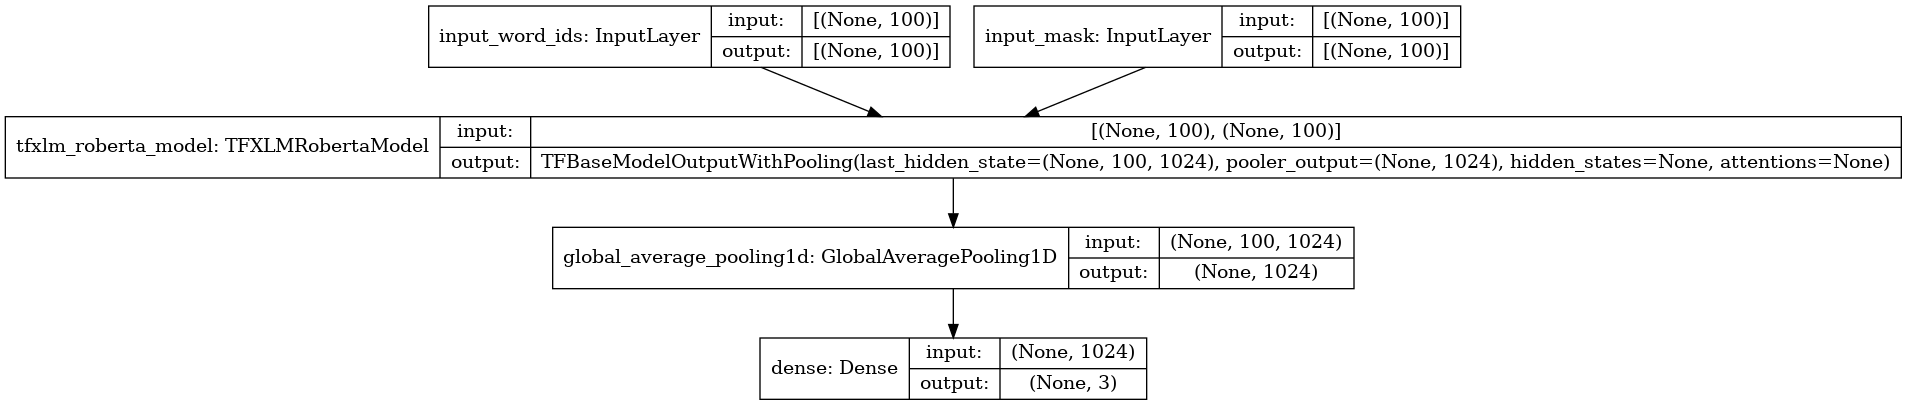

In [18]:
# instantiating the model in the strategy scope creates the model on the TPU

with strategy.scope(): # KM: defines the compute distribution policy for building the model. or in other words: makes sure that the model is created on the TPU/GPU/CPU, depending on to what the Accelerator is set in the Notebook Settings
    model = build_model() # KM: our model is being built
    model.summary()       # KM: let's look at some of its properties

tf.keras.utils.plot_model(model, "my_model.png", show_shapes=True) # KM: I added this line because it gives a nice visualization showing the individual components of our model

--**edits by [@Katharina Menz](https://www.kaggle.com/katharinamenz): The graph above illustrates in a very detailed way what our model and its inputs look like: input_word_ids, input_mask, and input_type_ids are the 3 input variables for the BERT model, which in turn returns a tuple. The word embeddings that are stored in the first entry of the tuple are then given to the classifier which then returns 3 categorical probabilities. The question marks stand for the number of rows in the input data which are of course unknown.**--

In [19]:
model.layers[3].trainable=True

In [20]:
for key in train_input.keys():
    train_input[key] = train_input[key][:,:max_len]

In [21]:
train_input

{'input_word_ids': <tf.Tensor: shape=(12120, 100), dtype=int32, numpy=
 array([[    3,   136,  6097, ...,     0,     0,     0],
        [    3, 32255,   621, ...,     0,     0,     0],
        [    3,  5581, 69332, ...,     0,     0,     0],
        ...,
        [    3,   581,  5526, ...,     0,     0,     0],
        [    3,  1913,    70, ...,     0,     0,     0],
        [    3,  1326, 66570, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(12120, 100), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [22]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)
# KM: make sure that TPU in Accelerator under Notebook Settings is turned on so that model trains on the TPU. Otherwise this line will crash
model.fit(train_input, train.label.values, epochs = 20, verbose = 1, validation_split = 0.2,
         batch_size=16*strategy.num_replicas_in_sync
          ,callbacks=[early_stop]
         ) # KM: now we fit the model to our training data that we prepared before. The number of training epochs is 2, verbose = 1 shows progress bar, # of rows in each batch is 64, and 20% of the data is used for validation

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


76/76 [==============================] - 272s 2s/step - loss: 0.3312 - accuracy: 0.8842 - val_loss: 0.2376 - val_accuracy: 0.9158
Epoch 2/20
76/76 [==============================] - 20s 269ms/step - loss: 0.1546 - accuracy: 0.9492 - val_loss: 0.2388 - val_accuracy: 0.9175
Epoch 3/20
76/76 [==============================] - 20s 270ms/step - loss: 0.1028 - accuracy: 0.9623 - val_loss: 0.2991 - val_accuracy: 0.9150


In [23]:
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer) # KM: finally we prepare our competition data for the model

In [24]:
for key in test_input.keys():
    test_input[key] = test_input[key][:,:max_len]

In [25]:
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


## Generating & Submitting Predictions

In [26]:
predictions = [np.argmax(i) for i in model.predict(test_input)] # KM: have the model predict three categorical probabilities, choose the highest probability, and save the respective label ID (0,1, or 2)

The submission file will consist of the ID column and a prediction column. We can just copy the ID column from the test file, make it a dataframe, and then add our prediction column.

In [27]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

In [28]:
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1


In [29]:
submission.to_csv("submission.csv", index = False)

And now we've created our submission file, which can be submitted to the competition. Good luck!